In [2]:
%store -r __imp

In [3]:
__imp

Tickle


In [3]:
#import lightgbm as lgb

In [13]:
new= pd.read_csv( 'new_merchant_transactions.csv')
his= pd.read_csv( 'historical_transactions.csv')
train= pd.read_csv('train.csv')
test= pd.read_csv( 'test.csv')

In [4]:
def downcast( df):
    start_mem= df.memory_usage().sum()/1024**2
    for col in df.columns:
        col_type= df[col].dtype
        if col_type != object:
            col_min= df[col].min()
            col_max= df[col].max()
            if str(col_type)[:3] == 'int':
                if np.iinfo(np.int8).min < col_min and np.iinfo(np.int8).max>col_max:
                    df[col]= df[col].astype(np.int8)
                elif np.iinfo(np.int16).min < col_min and np.iinfo(np.int16).max>col_max:
                    df[col]= df[col].astype(np.int16)
                elif np.iinfo(np.int32).min < col_min and np.iinfo(np.int32).max>col_max:
                    df[col]= df[col].astype(np.int32)
                elif np.iinfo(np.int64).min < col_min and np.iinfo(np.int64).max>col_max:
                    df[col]= df[col].astype(np.int64)
                   #df[float_cols] = df[float_cols].astype(np.float32)

            else:
                if np.finfo(np.float16).min < col_min and np.finfo(np.float16).max>col_max:
                    df[col]= df[col].astype(np.float16)
                elif np.finfo(np.float32).min < col_min and np.finfo(np.float32).max>col_max:
                    df[col]= df[col].astype(np.int32)
                else:
                    df[col]= df[col].astype(np.float64)
    end_mem= df.memory_usage().sum()/1024**2
    print( 'Memory usage decreased from {:5.2f} to {:5.2f} Mb i.e {:.2f}%'
          .format(start_mem, end_mem, 100*(start_mem-end_mem)/start_mem))
    return df

In [7]:
new= downcast( new)
his= downcast( his)
new[:2]

Memory usage decreased from 209.67 to 114.20 Mb i.e 45.54%
Memory usage decreased from 3109.54 to 1749.11 Mb i.e 43.75%


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19


In [40]:
train[:2]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913


In [4]:
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import datetime
pd.options.display.max_columns= 30

In [9]:
le= preprocessing.LabelEncoder()
le.fit( ['N','Y'])
for col in ['authorized_flag', 'category_1']:
    new[col]= le.transform( new[col])
    his[col]= le.transform( his[col])

In [43]:
new[:2]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [10]:
train.first_active_month= pd.to_datetime( train.first_active_month)
test.first_active_month= pd.to_datetime( test.first_active_month)
his.purchase_date= pd.to_datetime(his.purchase_date)
new.purchase_date= pd.to_datetime(new.purchase_date)

In [46]:
train.first_active_month.max()

Timestamp('2018-02-01 00:00:00')

In [ ]:
train['elapsed_time']= ( datetime.date( 2018,2,1) - 
                          train.first_active_month.dt.date).dt.days
test['elapsed_time']= ( datetime.date( 2018,2,1) - 
                          test.first_active_month.dt.date).dt.days

In [48]:
train[:2]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396


In [11]:
target= train.target
del train['target']

In [50]:
his[:2]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,0,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,0,2017-07-15 12:10:45,1.0,16,16


In [12]:
his[ 'month_diff']= (( datetime.datetime.today() - his.purchase_date).dt.days)//30
his.month_diff+= his.month_lag
new['month_diff']= (( datetime.datetime.today() - new. purchase_date).dt.days)//30
new.month_diff+= new.month_lag

In [52]:
new[:2]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19,11
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19,11


In [53]:
his.category_2.unique(), his.category_3.unique()

(array([ 1., nan,  3.,  5.,  2.,  4.]),
 array(['A', 'B', 'C', nan], dtype=object))

In [13]:
his= pd.get_dummies( his, columns=['category_2', 'category_3'])
new= pd.get_dummies( new, columns=['category_2', 'category_3'])

In [55]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 21 columns):
authorized_flag         int64
card_id                 object
city_id                 int16
category_1              int64
installments            int16
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float16
purchase_date           datetime64[ns]
state_id                int8
subsector_id            int8
month_diff              int64
category_2_1.0          uint8
category_2_2.0          uint8
category_2_3.0          uint8
category_2_4.0          uint8
category_2_5.0          uint8
category_3_A            uint8
category_3_B            uint8
category_3_C            uint8
dtypes: datetime64[ns](1), float16(1), int16(3), int64(3), int8(3), object(2), uint8(8)
memory usage: 125.4+ MB


In [56]:
his.authorized_flag.unique(),new.authorized_flag.unique()

(array([1, 0]), array([1]))

In [14]:
auth_mean= his.groupby(['card_id']).agg({'authorized_flag':['mean']})

In [58]:
auth_mean.columns

MultiIndex(levels=[['authorized_flag'], ['mean']],
           labels=[[0], [0]])

In [59]:
auth_mean[:2]

,authorized_flag
,mean
card_id,
C_ID_00007093c1,0.765101
C_ID_0001238066,0.975610


In [15]:
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

In [61]:
auth_mean[:2]

,card_id,authorized_flag_mean
0,C_ID_00007093c1,0.765101
1,C_ID_0001238066,0.975610


In [62]:
pd.DataFrame(his.groupby('card_id').authorized_flag.mean()).reset_index()[:2]

,card_id,authorized_flag
0,C_ID_00007093c1,0.765101
1,C_ID_0001238066,0.975610


In [16]:
auth_trans= his[ his.authorized_flag == 1]
non_auth_trans= his[ his.authorized_flag == 0]
auth_trans['purchase_month']= auth_trans.purchase_date.dt.month
non_auth_trans['purchase_month']= non_auth_trans.purchase_date.dt.month
new['purchase_month']= new.purchase_date.dt.month

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [64]:
pd.DatetimeIndex( non_auth_trans.purchase_date)

DatetimeIndex(['2017-04-07 12:58:09', '2017-09-17 22:40:27',
               '2017-09-17 22:40:26', '2018-02-20 10:57:50',
               '2017-07-08 07:33:31', '2017-03-22 15:53:08',
               '2017-07-08 07:32:30', '2017-07-08 07:32:49',
               '2017-03-22 15:52:52', '2017-09-07 20:57:19',
               ...
               '2017-10-27 00:15:12', '2017-08-04 12:31:03',
               '2017-08-04 12:32:17', '2017-08-04 12:32:02',
               '2017-08-04 12:33:15', '2017-07-29 19:32:29',
               '2017-10-12 19:03:34', '2018-01-15 10:34:33',
               '2017-03-04 20:46:25', '2017-07-15 08:17:49'],
              dtype='datetime64[ns]', name='purchase_date', length=2516909, freq=None)

In [65]:
pd.DatetimeIndex( non_auth_trans.purchase_date).astype('int64')/1e-9

Float64Index([1.4915698889999998e+27,        1.505688027e+27,
                     1.505688026e+27,         1.51912427e+27,
              1.4994992109999998e+27, 1.4901979879999998e+27,
              1.4994991499999999e+27,        1.499499169e+27,
                     1.490197972e+27,        1.504817839e+27,
              ...
                     1.509063312e+27, 1.5018498629999999e+27,
                     1.501849937e+27,        1.501849922e+27,
                     1.501849995e+27,        1.501356749e+27,
                     1.507835014e+27, 1.5160124729999998e+27,
                     1.488660385e+27,        1.500106669e+27],
             dtype='float64', name='purchase_date', length=2516909)

In [17]:
def aggregator( df):
    df.loc[:, 'purchase_date']= pd.DatetimeIndex( df.purchase_date).astype(np.int64)*1e-9
    agg_func= {
        'category_1' : ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['mean', 'max', 'min', 'std'],
        'month_diff': ['mean']
    }
    agg_df= df.groupby('card_id').agg( agg_func)
    agg_df.columns= [ '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index( inplace= True)
    agg_size= df.groupby('card_id').size().reset_index(name='transactions_count')
    agg_df= pd.merge( agg_df, agg_size, on= 'card_id', how= 'left')
    return agg_df

In [18]:
non_auth_trans_agg= aggregator( non_auth_trans)
non_auth_trans_agg[:2]

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,card_id,category_1_sum,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,category_3_A_mean,category_3_B_mean,category_3_C_mean,merchant_id_nunique,merchant_category_id_nunique,state_id_nunique,city_id_nunique,...,installments_min,installments_std,purchase_month_mean,purchase_month_max,purchase_month_min,purchase_month_std,purchase_date_ptp,purchase_date_min,purchase_date_max,month_lag_mean,month_lag_max,month_lag_min,month_lag_std,month_diff_mean,transactions_count
0,C_ID_00007093c1,4,0.114286,0.000000,0.0,0.885714,0.0,0.000000,0.0,0.828571,0.171429,11,8,2,3,...,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,11.057143,35
1,C_ID_0001238066,0,0.000000,0.333333,0.0,0.000000,0.0,0.666667,0.0,1.000000,0.000000,2,1,2,2,...,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,11.000000,3


In [19]:
new_agg= aggregator( new)
auth_trans_agg= aggregator( auth_trans)
auth_trans_agg.columns= [ 'auth_' + col if col != 'card_id' else col for col in auth_trans_agg.columns]
non_auth_trans_agg.columns= [ 'nauth_' + col if col != 'card_id' else col for col in non_auth_trans_agg.columns]
new_agg.columns= [ 'new_'+ col if col != 'card_id' else col for col in new_agg.columns]

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
def aggergator_monthly( df):
    agg_func= {
        'purchase_amount':[ 'count', 'sum', 'mean', 'min', 'max', 'std'],
        'installments':[ 'count', 'sum', 'mean', 'min', 'max', 'std']
    }
    intermediate= df.groupby(['card_id','month_lag']).agg( agg_func)
    intermediate.columns= [ '_'.join(col).strip() for col in intermediate.columns.values]
    intermediate.reset_index( inplace= True)
    final= intermediate.groupby('card_id').agg(['mean','std'])
    final.columns= [ '_'.join(col).strip() for col in final.columns.values]
    final.reset_index( inplace= True)
    return final

In [21]:
final= aggergator_monthly( auth_trans)
final[:3]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,0.076923,0.27735,0.005495,0.019811,0.0,0.0,0.076923,0.27735,0.020559,0.074125,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,0.076923,0.27735,0.019231,0.069338,0.0,0.0,0.076923,0.27735,0.041667,0.144338,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
def aggregator_successive( df, col1, col2):
    t= df.groupby( ['card_id', col1])[col2].mean()
    u= pd.DataFrame( t).reset_index().groupby('card_id')[col2] \
        .agg(['mean', 'min','max','std'])
    u.columns= [ col1+'_'+col2+'_'+col for col in u.columns.values]
    u.reset_index( inplace= True)
    return u

In [23]:
field= aggregator_successive( new, 'category_1','purchase_amount')
field= field.merge( aggregator_successive( 
        new, 'installments','purchase_amount'), on='card_id', how= 'left')
field= field.merge( aggregator_successive( 
        new, 'city_id','purchase_amount'), on='card_id', how= 'left')
field= field.merge( aggregator_successive( 
        new,'category_1', 'installments'), on='card_id', how= 'left')

In [73]:
field[:2]

,card_id,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,C_ID_00007093c1,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.671875,-0.656738,0.010704,1.000000,1.000000,1.0,NaN
1,C_ID_0001238066,-0.607422,-0.650391,-0.564453,0.06076,-0.423828,-0.625977,-0.151978,0.222046,-0.558105,-0.666992,-0.472168,0.072632,2.479167,1.458333,3.5,1.443676


In [74]:
field[ field.card_id=='C_ID_00007093c1']

,card_id,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,C_ID_00007093c1,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.664062,-0.664062,NaN,-0.664062,-0.671875,-0.656738,0.010704,1.0,1.0,1.0,NaN


In [24]:
train= pd.merge( train, non_auth_trans_agg, on='card_id', how='left')
train= pd.merge( train, auth_trans_agg, on='card_id', how='left')
train= pd.merge( train, new_agg, on='card_id', how='left')
train= pd.merge( train, final, on='card_id', how='left')
train= pd.merge( train, auth_mean, on='card_id', how='left')
train= pd.merge( train, field, on='card_id', how='left')
test= pd.merge( test, non_auth_trans_agg, on='card_id', how='left')
test= pd.merge( test, auth_trans_agg, on='card_id', how='left')
test= pd.merge( test, new_agg, on='card_id', how='left')
test= pd.merge( test, final, on='card_id', how='left')
test= pd.merge( test, auth_mean, on='card_id', how='left')
test= pd.merge( test, field, on='card_id', how='left')

In [ ]:
unimportant_features = ['auth_category_2_1.0_mean','auth_category_2_2.0_mean',
 'auth_category_2_3.0_mean','auth_category_2_5.0_mean','nauth_category_2_3.0_mean',
 'nauth_category_2_4.0_mean','nauth_category_2_5.0_mean','nauth_category_3_A_mean',
 'nauth_installments_min','nauth_installments_std','nauth_month_lag_std',
 'nauth_purchase_amount_max','nauth_purchase_month_max','nauth_purchase_month_min',
 'nauth_purchase_month_std','installments_min_mean','new_category_2_1.0_mean',
 'new_category_2_2.0_mean','new_category_2_3.0_mean','new_category_2_5.0_mean',
 'new_city_id_nunique','new_installments_std','new_state_id_nunique',
 'purchase_amount_mean_mean']
train.to_csv( 'train_processed.csv')
test.to_csv( 'test_processed.csv')

In [8]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

In [10]:
param = {#'max_leaf_nodes': 2**7,
         'min_child_weight': 5, 
         'objective':'reg:linear',
         'max_depth': 7,
         'learning_rate': 0.1,
         "eval_metric": 'rmse',
         "alpha": 0.2634,
         "seed": 133,
         "colsample_bytree": 0.75,
         'subsample':0.8,
         #'n_estimators': 2,
         'n_jobs': 1
         #"booster": "gbtree",
         #"bagging_freq": 1,
         #"bagging_fraction": 0.7083 ,
         #"bagging_seed": 11,
         #"verbosity": 0
        }
#clf= xgb.train( param, xgb.DMatrix(train.loc[ :, features], target),num_boost_round=2)
#clf.fit( xgb.DMatrix(train.loc[ :, features]), xgb.DMatrix(target))
#print( mean_squared_error( target, clf.predict_proba( train[features]))**0.5)
#preds= clf.get_fscore( xgb.DMatrix(test[ features]))

In [11]:
folds= KFold( n_splits= 5, shuffle= True, random_state= 15)
oof= np.zeros( len( train))
predictions= np.zeros( len( test))
feature_imp_df= pd.DataFrame()
for i, (train_idx, val_idx) in enumerate( folds.split( train.values, target.values)):
    print('Fold {}'.format(i))
    train_data= xgb.DMatrix( train.loc[ train_idx, features], 
                                label= target.iloc[ train_idx])
    val_data= xgb.DMatrix( train.loc[ val_idx, features], 
                                label= target.iloc[ val_idx])
    clf= xgb.train( param, train_data, num_boost_round= 5000, 
                    evals= ([(val_data, 'validation')]), 
                    verbose_eval= 10, early_stopping_rounds= 200)
    best_iteration= clf.best_ntree_limit
    oof[ val_idx]= clf.predict( xgb.DMatrix(train.loc[ val_idx, features]),
                                 ntree_limit= best_iteration)
    fold_imp_df= pd.DataFrame()
    fold_imp_df['feature']= features
    #print( clf.booster().get_fscore())
    b= clf.get_fscore()
    feat_imp= []
    for j in features:
        if j in b.keys():
            feat_imp.append( b[ j])
        else:
            feat_imp.append( 0)
    fold_imp_df['imp']= feat_imp
    fold_imp_df['fold']= i + 1
    feature_imp_df= pd.concat( [ feature_imp_df, fold_imp_df], axis= 0)
    predictions+= clf.predict( xgb.DMatrix(test[ features]), 
                        ntree_limit= best_iteration)/folds.n_splits
print( 'CV score: {:<8.5f}'.format( mean_squared_error( oof, target)**0.5))

Fold 0
[14:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:3.94115
Will train until validation-rmse hasn't improved in 200 rounds.
[14:25:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[14:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[14:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=7
[14:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[14:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[14:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[14:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth

[70]	validation-rmse:3.69041
[14:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[14:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[14:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[14:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[14:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[14:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[14:28:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[14:28:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[14:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 

[14:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[14:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[14:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[14:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[14:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[14:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[14:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[14:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[14:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned no

[14:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[14:32:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[14:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[14:32:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[14:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[14:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[14:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[14:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[220]	validation-rmse:3.71192
[14:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[14:34:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[14:34:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[14:34:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[14:34:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[14:34:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[14:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[14:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[30]	validation-rmse:3.63797
[14:34:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[14:34:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[14:36:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[14:36:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[14:36:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[14:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[14:36:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[14:36:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[100]	validation-rmse:3.6402
[14:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[14:36:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[14:36:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 

[14:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[14:38:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[14:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[14:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[14:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[170]	validation-rmse:3.65113
[14:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=7
[14:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[14:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[14:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

Stopping. Best iteration:
[36]	validation-rmse:3.63449

Fold 2
[14:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation-rmse:3.83176
Will train until validation-rmse hasn't improved in 200 rounds.
[14:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[14:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=7
[14:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=7
[14:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=7
[14:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=7
[14:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[14:41:02] src/tree/updater_prune.cc:74: tree pruning 

[14:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[70]	validation-rmse:3.62107
[14:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[14:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[14:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[14:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[14:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[14:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[14:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[14:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1

[140]	validation-rmse:3.63257
[14:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[14:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[14:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[14:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[14:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[14:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[14:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[14:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[14:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[14:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[14:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[14:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[14:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[14:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[14:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[14:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[14:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[14:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned node

[14:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[14:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[14:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[14:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[40]	validation-rmse:3.80161
[14:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=7
[14:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[14:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[14:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[14:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[14:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[14:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[14:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[110]	validation-rmse:3.80075
[14:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[14:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[14:51:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[14:51:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[14:51:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[14:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[14:53:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[14:53:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[180]	validation-rmse:3.81134
[14:53:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[14:53:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[14:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[14:53:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[14:53:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[14:53:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[14:53:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[14:55:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[250]	validation-rmse:3.81802
[14:55:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[14:55:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=7
[14:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[14:55:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[14:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[14:55:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[14:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[14:55:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[14:57:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=7
[14:57:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[14:57:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[14:57:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=7
[30]	validation-rmse:3.6404
[14:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[14:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[14:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[14:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[14:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1

[14:59:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[14:59:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[14:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=7
[100]	validation-rmse:3.6547
[14:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[14:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[14:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[14:59:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[14:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[15:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1

[15:01:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[15:01:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[170]	validation-rmse:3.66197
[15:01:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=7
[15:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[15:01:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[15:02:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[15:02:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[15:02:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[15:02:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

In [12]:
sub_df= pd.DataFrame( {'card_id': test.card_id})
sub_df['target']= predictions
sub_df.to_csv( 'submit2.csv', index= False)

In [52]:
print( 'CV score: {:<8.5f}'.format( mean_squared_error( np.clip(oof,-20,20), target)**0.5))

CV score: 3.67759 


In [5]:
train= pd.read_csv( 'train_processed.csv')
test= pd.read_csv( 'test_processed.csv')

In [6]:
target= pd.read_csv( 'train.csv', usecols=['target'])

In [15]:
predictions.min(), predictions.max()

(-3.839450031518936, 0.8263798207044601)

In [44]:
#train_data= xgb.DMatrix( train.loc[ :, features], label= target)
#clf= xgb.train( param, train_data, num_boost_round= 10)

In [9]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}
import lightgbm as lgb
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71669	valid_1's rmse: 3.77741
[200]	training's rmse: 3.64894	valid_1's rmse: 3.72997
[300]	training's rmse: 3.60718	valid_1's rmse: 3.70744
[400]	training's rmse: 3.57783	valid_1's rmse: 3.69585
[500]	training's rmse: 3.55596	valid_1's rmse: 3.6893
[600]	training's rmse: 3.53763	valid_1's rmse: 3.68513
[700]	training's rmse: 3.52283	valid_1's rmse: 3.68225
[800]	training's rmse: 3.50959	valid_1's rmse: 3.6803
[900]	training's rmse: 3.49735	valid_1's rmse: 3.67899
[1000]	training's rmse: 3.48601	valid_1's rmse: 3.67776
[1100]	training's rmse: 3.47508	valid_1's rmse: 3.67666
[1200]	training's rmse: 3.46468	valid_1's rmse: 3.67622
[1300]	training's rmse: 3.4545	valid_1's rmse: 3.67577
[1400]	training's rmse: 3.44497	valid_1's rmse: 3.6755
[1500]	training's rmse: 3.43505	valid_1's rmse: 3.67528
[1600]	training's rmse: 3.42577	valid_1's rmse: 3.67533
[1700]	training's rmse: 3.41698	valid_1's rmse: 3.6753

In [44]:
len(features), len( feat_imp)

(138, 138)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


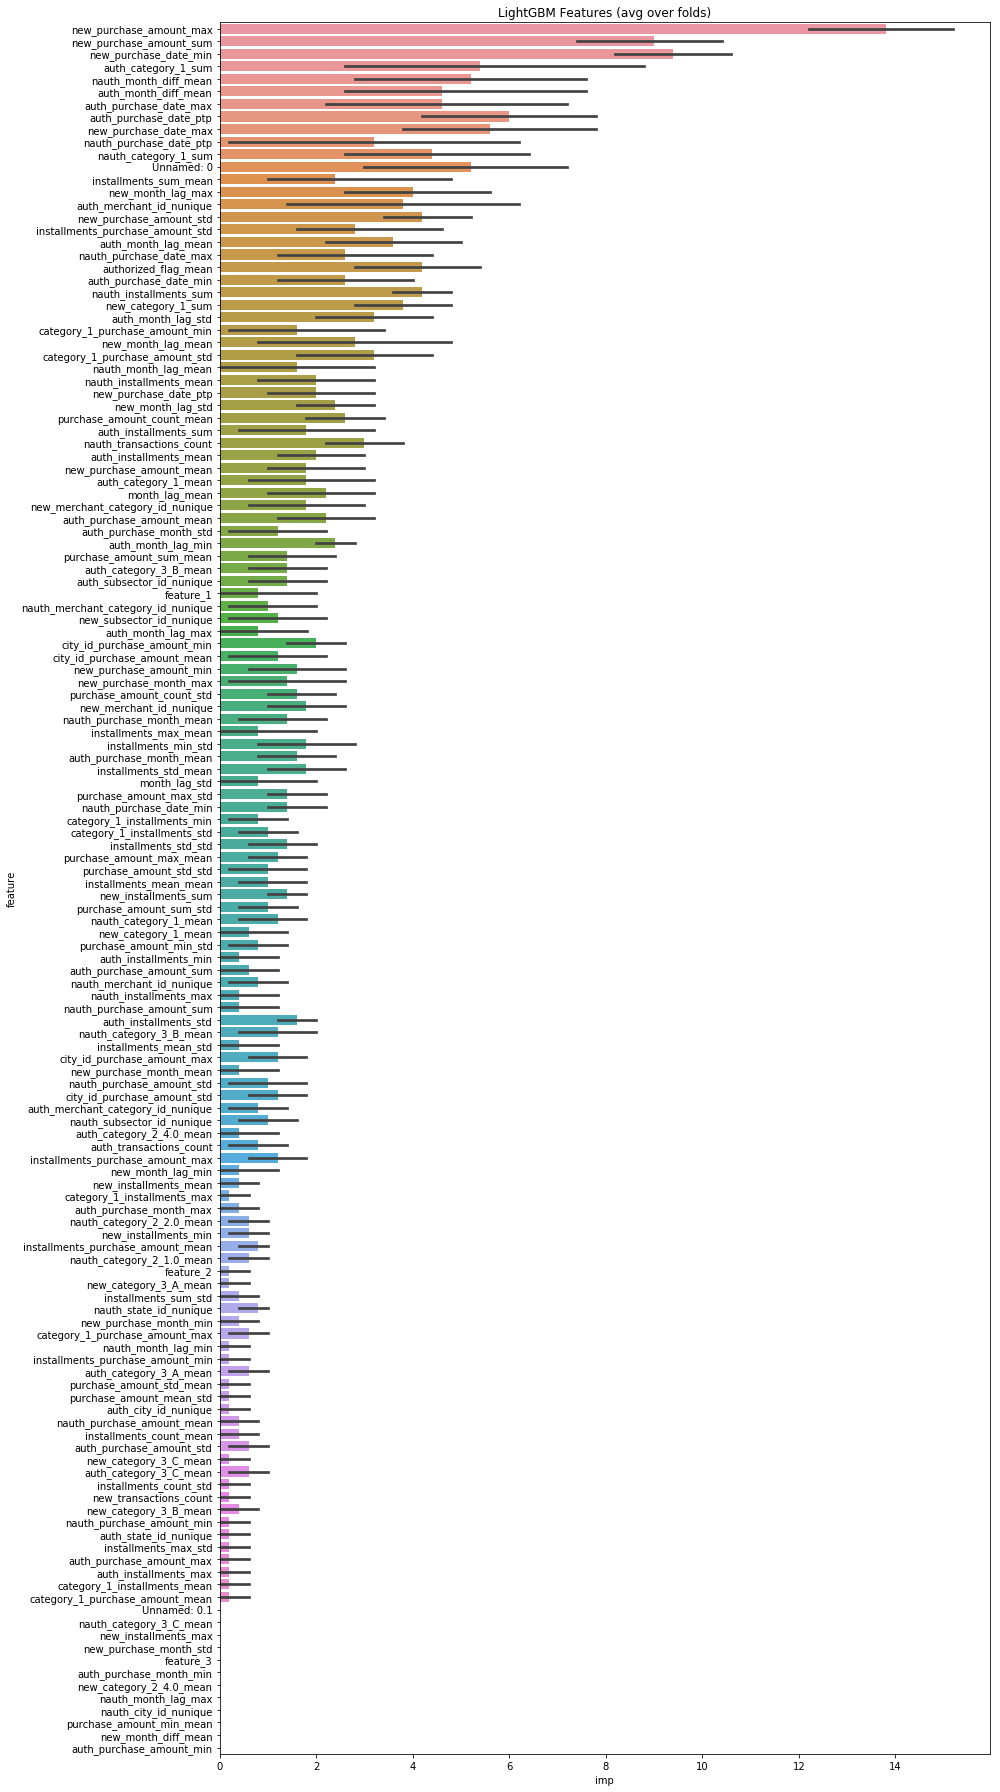

In [58]:
cols = (feature_imp_df[["feature", "imp"]]
        .groupby("feature")
        .mean()
        .sort_values(by="imp", ascending=False)[:1000].index)

best_features = feature_imp_df.loc[feature_imp_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
import seaborn as sns
sns.barplot(x="imp",
            y="feature",
            data=best_features.sort_values(by="imp",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

(array([ 9568., 16482., 27288., 23312., 12872.,  9691.,  4379.,   946.,
          270.,    65.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <a list of 10 Patch objects>)

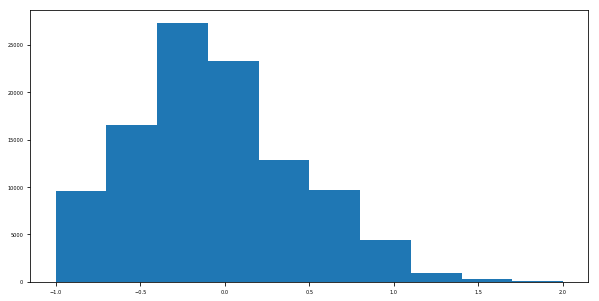

In [43]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rc('ytick', labelsize=5)
plt.rc('xtick', labelsize=5)
#plt.rcParams.update({'font.size': 2})
plt.hist( predictions,bins= 10,range=[-1, 2])

In [67]:
len(predictions)

123623

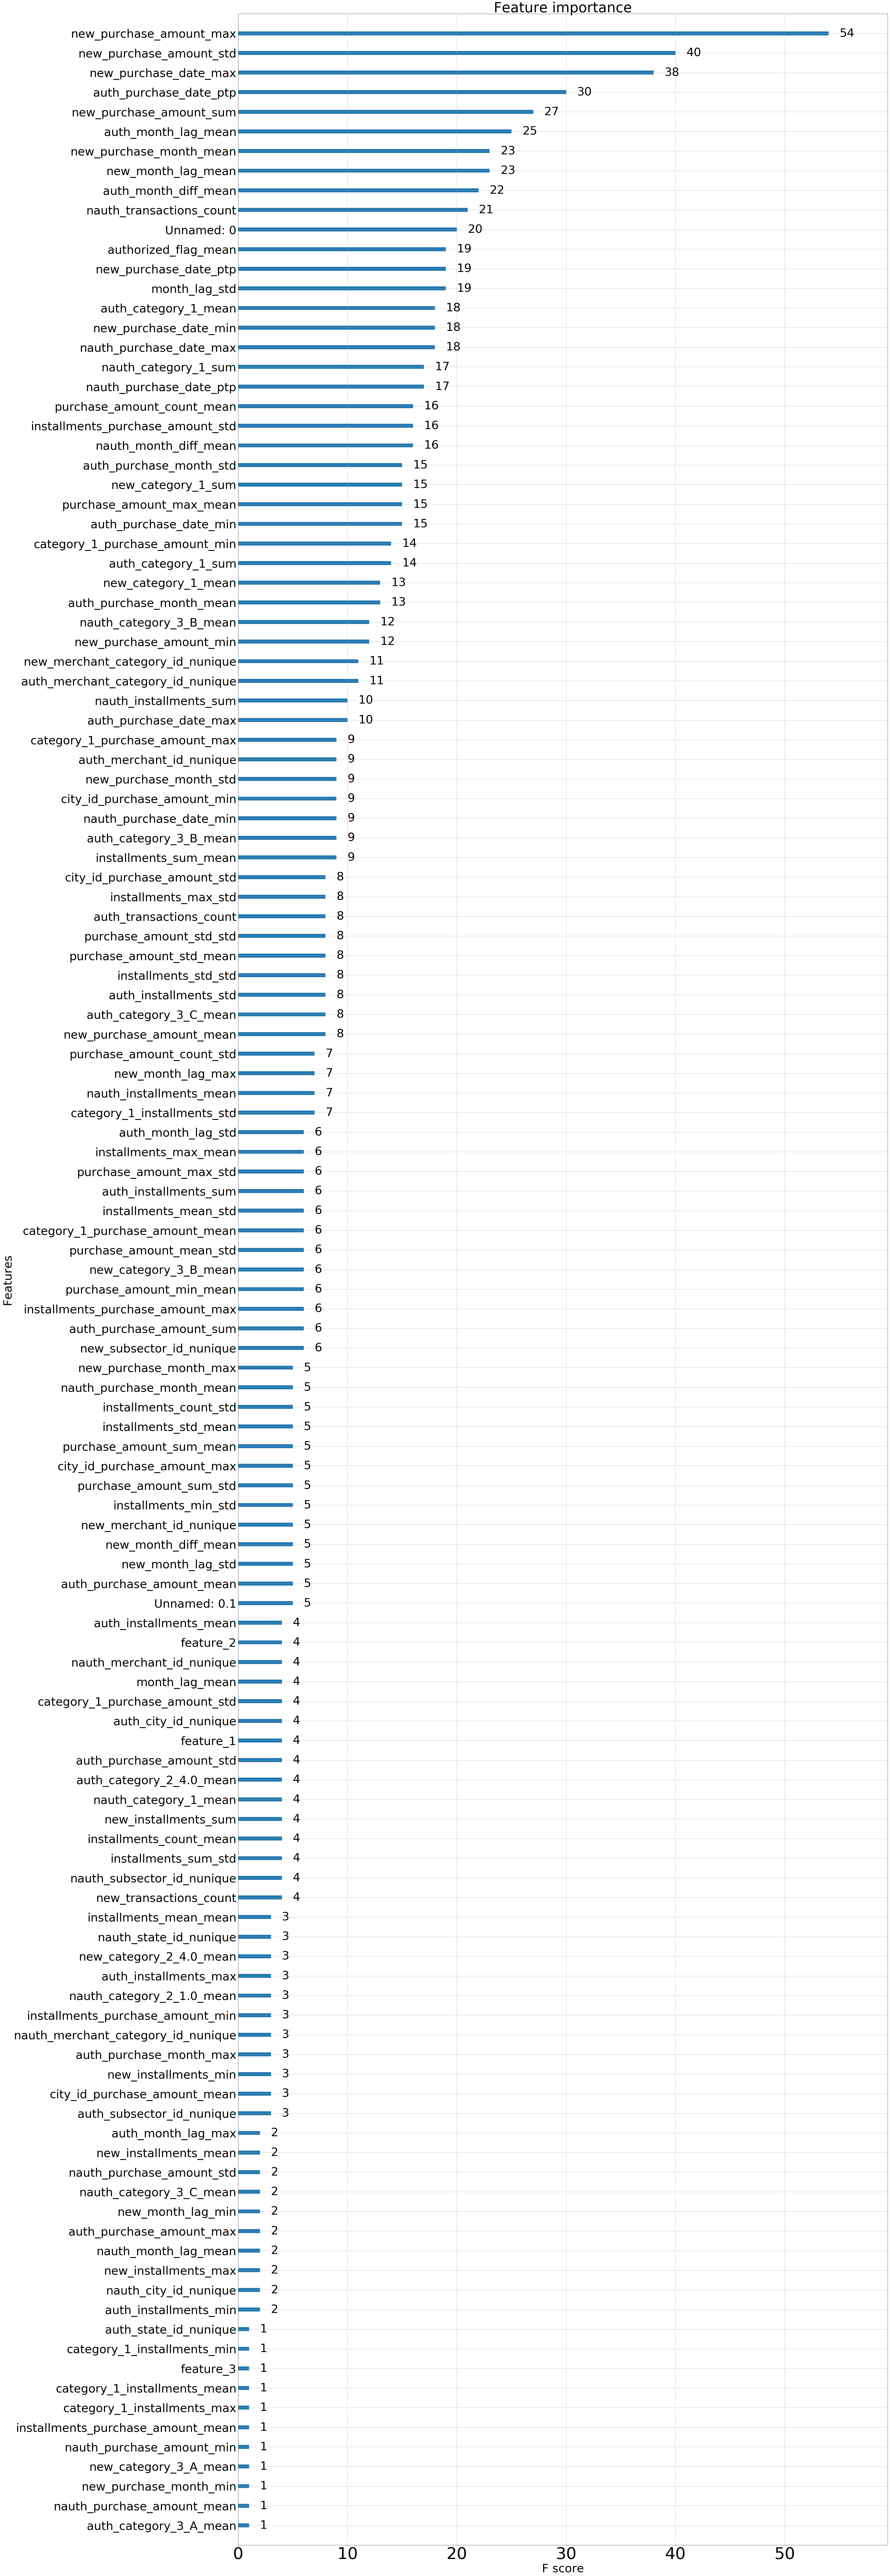

In [38]:
#xg_reg= xgb.train( param, xgb.DMatrix(train[ features], label=target), num_boost_round= 10)
plt.rcParams['figure.figsize'] = [50, 200]
#plt.rc('ytick', labelsize=50)
plt.rcParams.update({'font.size': 50})
#plt.rc('xtick', labelsize=70)
#plt.ylabel( width= 6, length= 10)
xgb.plot_importance( xg_reg)

In [48]:
target.min(), target.max()

(target   -33.219281
 dtype: float64, target    17.965068
 dtype: float64)

In [51]:
predictions.min(), predictions.max()

(-18.12532114982605, 3.99050110578537)

In [10]:
train.shape

(201917, 166)

In [11]:
his[:2]

NameError: name 'his' is not defined